In [17]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import copy
import mpl_scatter_density
import numpy as np
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns; sns.set()
import geohash as gh
from haversine import haversine
%matplotlib inline

In [21]:
data = pd.read_csv('data_cleaned.csv')
data.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_hour,distance,speed
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,1.498523,11.856445
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.805510,9.803672
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,6.385107,10.822216
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,1.485500,12.465738
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,1.188590,9.836608


**Convert time to Categorical Variables**

Cylical time: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [57]:
def convert_time(data):
    df = data.copy()
    # convert to datetime object
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)
    df['pickup_day'] = pd.to_datetime(data.pickup_datetime).dt.day
    df['pickup_weekday'] = pd.to_datetime(data.pickup_datetime).dt.day_name()
    df['pickup_month'] = pd.to_datetime(data.pickup_datetime).dt.month
    df['pickup_hour'] = pd.to_datetime(data.pickup_datetime).dt.hour
    df['pickup_week'] = pd.to_datetime(data.pickup_datetime).dt.weekofyear
    df['pickup_minute'] =  pd.to_datetime(data.pickup_datetime).dt.minute
    df['pickup_second'] =  pd.to_datetime(data.pickup_datetime).dt.second
    df['pickup_time'] =  df.pickup_hour + (df.pickup_minute / 60) + (df.pickup_second / (60*60))
    return df

# convert time to cylical variables
def time_to_cylical(data):
    # maps pickup hour+minute+second to the circumferece of a circle
    # hour
    df = data.copy()
    df['pickup_hour_sin'] = np.sin(df.pickup_time*(2.*np.pi/24))
    df['pickup_hour_cos'] = np.cos(df.pickup_time*(2.*np.pi/24))
    # day
    df['pickup_day_sin'] = np.sin((df.pickup_day-1)*(2.*np.pi/7))
    df['pickup_day_cos'] = np.cos((df.pickup_day-1)*(2.*np.pi/7))
    # week
    df['pickup_week_sin'] = np.sin((df.pickup_week-1)*(2.*np.pi/(12*4)))
    df['pickup_week_cos'] = np.cos((df.pickup_week-1)*(2.*np.pi/(12*4)))
    # month
    df['pickup_month_sin'] = np.sin((df.pickup_month-1)*(2.*np.pi/12))
    df['pickup_month_cos'] = np.cos((df.pickup_month-1)*(2.*np.pi/12))
    return df

# convert time features to categorical variables
def time_to_cat(data):
    df = data.copy()
    df_with_dummies = pd.get_dummies(df, columns=["pickup_weekday", "pickup_month", "pickup_hour"] , drop_first= True)
    return df_with_dummies

def location_to_cylical(data):
    df = data.copy()
    # pickup
    df['pickup_loc_x'] = np.cos(df.pickup_latitude) * np.cos(df.pickup_longitude)
    df['pickup_loc_y'] = np.cos(df.pickup_latitude) * np.sin(df.pickup_longitude)
    df['pickup_loc_z'] = np.sin(df.pickup_latitude)
    # dropoff
    df['dropoff_loc_x'] = np.cos(df.pickup_latitude) * np.cos(df.pickup_longitude)
    df['dropoff_loc_y'] = np.cos(df.pickup_latitude) * np.sin(df.pickup_longitude)
    df['dropoff_loc_z'] = np.sin(df.pickup_latitude)
    
    return df
    
def encode_cat(data):
    df = data.copy()
    # passenger count
    df_with_dummies = pd.get_dummies(df, columns=["passenger_count", "vendor_id", "store_and_fwd_flag"] , drop_first= True)
    return df_with_dummies

In [58]:
df = convert_time(data)
df = time_to_cylical(df)
df = location_to_cylical(df)
df = encode_cat(df)
df = time_to_cat(df)

In [59]:
list(df.columns.values)

['Unnamed: 0',
 'id',
 'pickup_datetime',
 'dropoff_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'trip_duration_hour',
 'distance',
 'speed',
 'pickup_day',
 'pickup_week',
 'pickup_minute',
 'pickup_second',
 'pickup_time',
 'pickup_hour_sin',
 'pickup_hour_cos',
 'pickup_day_sin',
 'pickup_day_cos',
 'pickup_week_sin',
 'pickup_week_cos',
 'pickup_month_sin',
 'pickup_month_cos',
 'pickup_loc_x',
 'pickup_loc_y',
 'pickup_loc_z',
 'dropoff_loc_x',
 'dropoff_loc_y',
 'dropoff_loc_z',
 'passenger_count_2',
 'passenger_count_3',
 'passenger_count_4',
 'passenger_count_5',
 'passenger_count_6',
 'vendor_id_2',
 'store_and_fwd_flag_Y',
 'pickup_weekday_Monday',
 'pickup_weekday_Saturday',
 'pickup_weekday_Sunday',
 'pickup_weekday_Thursday',
 'pickup_weekday_Tuesday',
 'pickup_weekday_Wednesday',
 'pickup_month_2',
 'pickup_month_3',
 'pickup_month_4',
 'pickup_month_5',
 'pickup_month_6',
 'pickup_hour_1',
 'pickup_hour

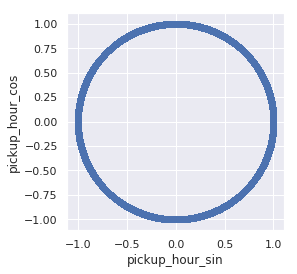

In [9]:
ax = df.plot.scatter('pickup_hour_sin', 'pickup_hour_cos').set_aspect('equal')

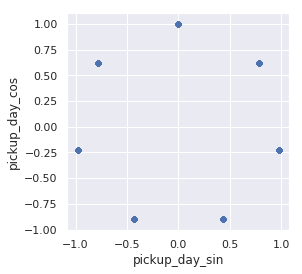

In [10]:
ax = df.plot.scatter('pickup_day_sin', 'pickup_day_cos').set_aspect('equal')

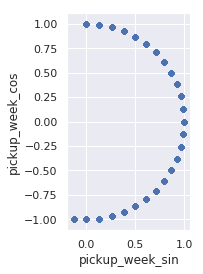

In [11]:
ax = df.plot.scatter('pickup_week_sin', 'pickup_week_cos').set_aspect('equal')

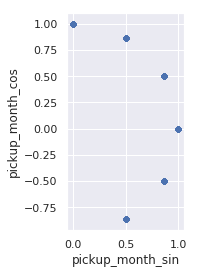

In [12]:
ax = df.plot.scatter('pickup_month_sin', 'pickup_month_cos').set_aspect('equal')

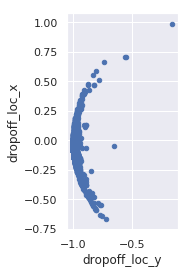

In [13]:
ax = df.plot.scatter('dropoff_loc_y', 'dropoff_loc_x').set_aspect('equal')

In [60]:
features = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'pickup_hour_sin',
    'pickup_hour_cos',
    'pickup_day_sin',
    'pickup_day_cos',
    'pickup_week_sin',
    'pickup_week_cos',
    'pickup_month_sin',
    'pickup_month_cos',
    'pickup_loc_x',
    'pickup_loc_y',
    'pickup_loc_z',
    'dropoff_loc_x',
    'dropoff_loc_y',
    'dropoff_loc_z',
    'passenger_count_2',
    'passenger_count_3',
    'passenger_count_4',
    'passenger_count_5',
    'passenger_count_6',
    'pickup_weekday_Monday',
    'pickup_weekday_Saturday',
    'pickup_weekday_Sunday',
    'pickup_weekday_Thursday',
    'pickup_weekday_Tuesday',
    'pickup_weekday_Wednesday',
    'pickup_month_2',
    'pickup_month_3',
    'pickup_month_4',
    'pickup_month_5',
    'pickup_month_6',
    'pickup_hour_1',
    'pickup_hour_2',
    'pickup_hour_3',
    'pickup_hour_4',
    'pickup_hour_5',
    'pickup_hour_6',
    'pickup_hour_7',
    'pickup_hour_8',
    'pickup_hour_9',
    'pickup_hour_10',
    'pickup_hour_11',
    'pickup_hour_12',
    'pickup_hour_13',
    'pickup_hour_14',
    'pickup_hour_15',
    'pickup_hour_16',
    'pickup_hour_17',
    'pickup_hour_18',
    'pickup_hour_19',
    'pickup_hour_20',
    'pickup_hour_21',
    'pickup_hour_22',
    'pickup_hour_23',
    'distance',
    'speed',
    'store_and_fwd_flag_Y',
    'trip_duration'
]

In [61]:
model_features = df[features]
model_features.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour_sin,pickup_hour_cos,pickup_day_sin,pickup_day_cos,pickup_week_sin,pickup_week_cos,...,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,distance,speed,store_and_fwd_flag_Y,trip_duration
0,-73.982155,40.767937,-73.964630,40.765602,-0.988306,-0.152483,-0.781831,0.623490,0.965926,0.258819,...,0,0,0,0,0,0,1.498523,11.856445,0,455
1,-73.980415,40.738564,-73.999481,40.731152,0.189024,0.981972,-0.433884,-0.900969,0.258819,-0.965926,...,0,0,0,0,0,0,1.805510,9.803672,0,663
2,-73.979027,40.763939,-74.005333,40.710087,0.107132,-0.994245,-0.433884,-0.900969,0.258819,0.965926,...,0,0,0,0,0,0,6.385107,10.822216,0,2124
3,-74.010040,40.719971,-74.012268,40.706718,-0.919622,0.392805,-0.974928,-0.222521,0.991445,-0.130526,...,0,1,0,0,0,0,1.485500,12.465738,0,429
4,-73.973053,40.793209,-73.972923,40.782520,-0.386376,-0.922342,-0.433884,-0.900969,0.991445,0.130526,...,0,0,0,0,0,0,1.188590,9.836608,0,435


In [62]:
file_name = 'engineered.csv'
model_features.to_csv(file_name, encoding='utf-8', index=False)